In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings
import seaborn as sns
plt.rcParams['font.family'] = 'serif'

# Set the font used for math expressions to LaTeX
plt.rcParams["mathtext.fontset"] = "cm"

In [2]:
# file paths
base_file = '/share/garg/311_data/sb2377/clean_codebase/three_year_base.csv'
type_rating_observed_base_file = '/share/garg/311_data/sb2377/clean_codebase/three_year_type_rating_observed_base.csv'
results_dir = '/share/garg/311_data/sb2377/results'

# user specified arguments
types = {'Street': 'StreetConditionDOT',
        'Park': 'MaintenanceorFacilityDPR',
        'Rodent': 'RodentDOHMH',
        'Food': 'FoodDOHMH',
        'DCWP': 'ConsumerComplaintDCWP'}
models = {'Full model': {'job_ids':[3000] + [i * 3 + 3005 for i in range(12)]},
        'Ratings-only model': {'job_ids':[3002] + [i * 3 + 3007 for i in range(12)]},
        'Reports-only model': {'job_ids':[3001] + [i * 3 + 3006 for i in range(12)]}}
epoch = '59'

# plotting parameters
fig1_size=(8, 2)
fig2_size=(8, 3)
fig1_save_path = '/home/sb2377/gnn_crowdsourced_model/figures/node_histogram.pdf'
fig2_save_path = '/home/sb2377/gnn_crowdsourced_model/figures/model_node_comparison.pdf'

In [3]:
# load files
base_df = pd.read_csv(base_file)
type_rating_observed_base_df = pd.read_csv(type_rating_observed_base_file)

In [4]:
# get type indices
# for df with all types
type_df = base_df[['typeagency', 'type_idxs']].drop_duplicates()
indices = {}
for type_name, type_id in types.items():
    idx = type_df[type_df['typeagency'] == type_id]['type_idxs'].iloc[0]
    indices[type_name] = idx

# for df with only types with observed ratings
type_df = type_rating_observed_base_df[['typeagency', 'type_idxs']].drop_duplicates()
type_rating_observed_indices = {}
for type_name, type_id in types.items():
    idx = type_df[type_df['typeagency'] == type_id]['type_idxs'].iloc[0]
    type_rating_observed_indices[type_name] = idx

In [5]:
# get predicted ratings for all jobs for types with observed ratings
checkpoint_file = '{}/job{}/model-epoch={}.ckpt'
results_file = '{}/job{}/epoch={}_test.pkl'
checkpoint_counters = {}
results_counters = {}
for m in models:
    checkpoint_counters[m] = 0
    results_counters[m] = 0
type_rating_observed_dfs = {}
for m in models:
    type_rating_observed_dfs[m] = []

for m in models:
    for i, job_idx in enumerate(models[m]['job_ids']):
        if os.path.exists(checkpoint_file.format(results_dir, job_idx, epoch)):
            checkpoint_counters[m] += 1
        if os.path.exists(results_file.format(results_dir, job_idx, epoch)):
            results_counters[m] += 1
            with open(results_file.format(results_dir, job_idx, epoch), 'rb') as file:
                pred_rating, true_rating, mask, node_embedding, type_embedding, node_idxs, type_idxs, demographics, pred_pt, true_t = pickle.load(file)

            df = pd.DataFrame()
            df['pred_rating'] = pred_rating
            df['true_rating'] = true_rating
            df['node_idxs'] = node_idxs
            df['type_idxs'] = type_idxs
            df['pred_pt'] = pred_pt
            df['true_t'] = true_t
            df['mask'] = mask

            type_rating_observed_dfs[m].append(df)

for m in models:
    print('{}: checkpoint files done = {}'.format(m, checkpoint_counters[m]))
    print('{}: results files done = {}'.format(m, results_counters[m]))

Full model: checkpoint files done = 13
Full model: results files done = 13
Ratings-only model: checkpoint files done = 13
Ratings-only model: results files done = 13
Reports-only model: checkpoint files done = 13
Reports-only model: results files done = 13


In [6]:
# Store data for plotting
all_errors = {}

# print out correlation and rmse results for predicted ratings
for t in types:
    idx = indices[t]
    df = type_rating_observed_dfs['Full model'][0]
    df_type = df[df['type_idxs'] == idx]
    node_df = df_type.groupby(['node_idxs', 'type_idxs']).mean().reset_index()

    pred_rating = node_df['pred_rating']
    true_rating = node_df['true_rating']
    
    # Element-wise errors
    absolute_errors = np.abs(pred_rating - true_rating)
    all_errors[t] = absolute_errors

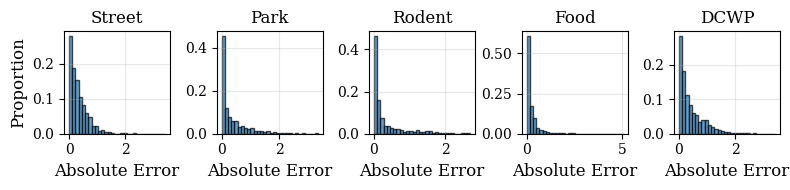

In [7]:
# Plot histograms side by side
n_types = len(types)
fig, axes = plt.subplots(1, n_types, figsize=fig1_size)

# Handle case of single type
if n_types == 1:
    axes = [axes]

for i, t in enumerate(types):
    errors = all_errors[t]
    weights = np.ones_like(errors) / len(errors)  # Each observation gets weight 1/n
    axes[i].hist(errors, bins=30, weights=weights, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel('Absolute Error', fontsize=12)
    if i == 0:
        axes[i].set_ylabel('Proportion', fontsize=12)
    axes[i].set_title(f'{t}', fontsize=12)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(fig1_save_path, format="pdf", bbox_inches="tight")

In [9]:
# collect rmse results for predicted ratings
all_errs = {}
for m in models:
    df_set = type_rating_observed_dfs[m]
    model_errs = []
    for t in types:
        idx = indices[t]
        type_rating_observed_idx = type_rating_observed_indices[t]

        type_errs = []

        for df in df_set:
            df_type = df[df['type_idxs'] == idx]
            if m == 'Ratings-only model':
                df_type = df[df['type_idxs'] == type_rating_observed_idx]
            else:
                df_type = df[df['type_idxs'] == idx]
            node_df = df_type.groupby(['node_idxs', 'type_idxs']).mean().reset_index()

            with warnings.catch_warnings():
                if m == 'Reports-only model':
                    # for reports-only model, we use -P(T) as a proxy for r
                    pred_rating = -1 * node_df['pred_pt']
                else:
                    pred_rating = node_df['pred_rating'].values

            true_rating = node_df['true_rating'].values
            absolute_errors = np.abs(pred_rating - true_rating)
            type_errs.append(absolute_errors)
        model_errs.append(type_errs)
    all_errs[m] = model_errs

flattened_errs = {}
for m in models:
    err_list = [err for type_errs in all_errs[m] for err in type_errs]
    flattened_errs[m] = np.concatenate(err_list)

In [10]:
# Function to bin data and calculate statistics
def bin_data_with_errors(x, y, n_bins=20):
    # Create bins
    bins = np.linspace(x.min(), x.max(), n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate mean and std for each bin
    bin_means = []
    bin_stds = []
    bin_counts = []
    
    for i in range(n_bins):
        mask = (x >= bins[i]) & (x < bins[i+1])
        y_in_bin = y[mask]
        
        if len(y_in_bin) > 0:
            bin_means.append(np.mean(y_in_bin))
            bin_stds.append(np.std(y_in_bin))
            bin_counts.append(len(y_in_bin))
        else:
            bin_means.append(np.nan)
            bin_stds.append(np.nan)
            bin_counts.append(0)
    
    return bin_centers, np.array(bin_means), np.array(bin_stds), np.array(bin_counts)

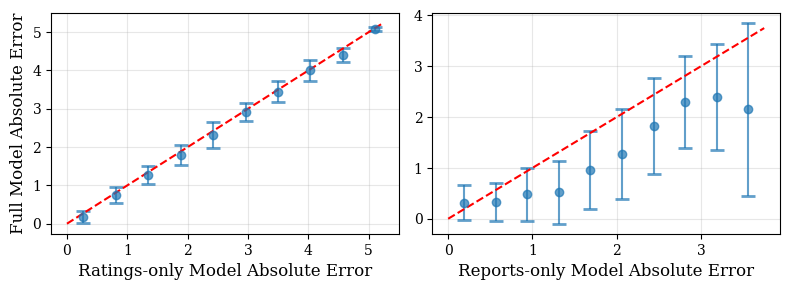

In [11]:
full_model_errs = flattened_errs['Full model']
ratings_only_errs = flattened_errs['Ratings-only model']
reports_only_errs = flattened_errs['Reports-only model']

# Create plots
fig, axes = plt.subplots(1, 2, figsize=fig2_size)

# Plot 1: Full model vs Ratings-only model
bin_centers_1, bin_means_1, bin_stds_1, bin_counts_1 = bin_data_with_errors(
    ratings_only_errs, full_model_errs, n_bins=10
)

axes[0].errorbar(bin_centers_1, bin_means_1, yerr=bin_stds_1, 
                 fmt='o', capsize=5, capthick=2, markersize=6, alpha=0.7)
max_val_1 = min(ratings_only_errs.max(), full_model_errs.max())
axes[0].plot([0, max_val_1], [0, max_val_1], 'r--', label='y=x')
axes[0].set_ylabel('Full Model Absolute Error', fontsize=12)
axes[0].set_xlabel('Ratings-only Model Absolute Error', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: Full model vs Reports-only model
bin_centers_2, bin_means_2, bin_stds_2, bin_counts_2 = bin_data_with_errors(
    reports_only_errs, full_model_errs, n_bins=10
)

axes[1].errorbar(bin_centers_2, bin_means_2, yerr=bin_stds_2, 
                 fmt='o', capsize=5, capthick=2, markersize=6, alpha=0.7)
max_val_2 = min(reports_only_errs.max(), full_model_errs.max())
axes[1].plot([0, max_val_2], [0, max_val_2], 'r--', label='y=x')
axes[1].set_xlabel('Reports-only Model Absolute Error', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(fig2_save_path, format="pdf", bbox_inches="tight")